# Exercises

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
from wordcloud import WordCloud

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/skylerschnee/nltk_data...


True

In [16]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/skylerschnee/nltk_data...


True

## Spam Data

#### Load the spam data set.

In [2]:
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))

In [8]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [9]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [10]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


In [17]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [18]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

### Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [19]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

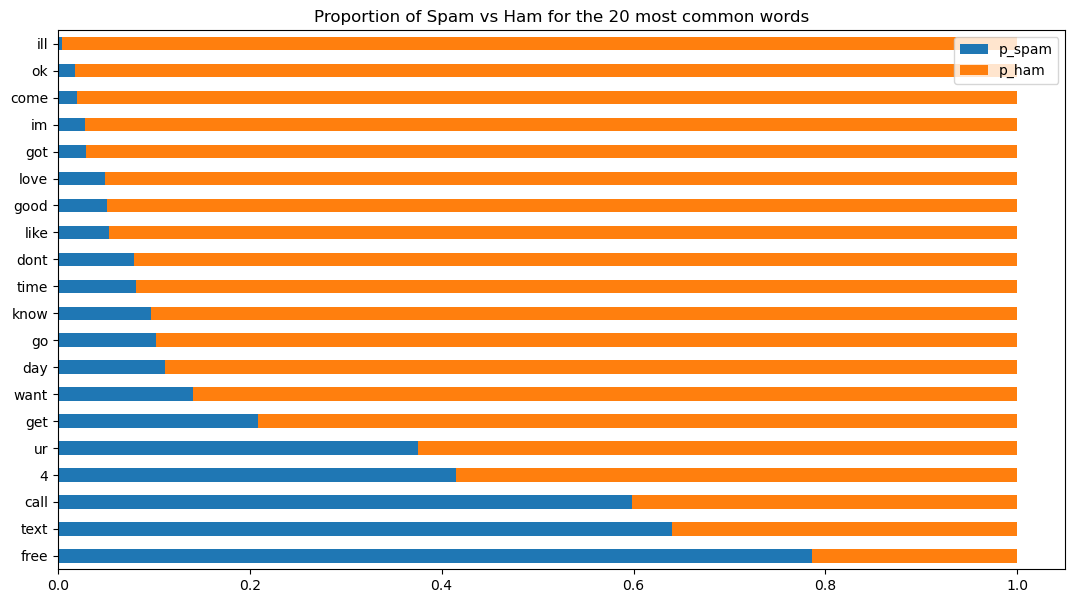

In [20]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

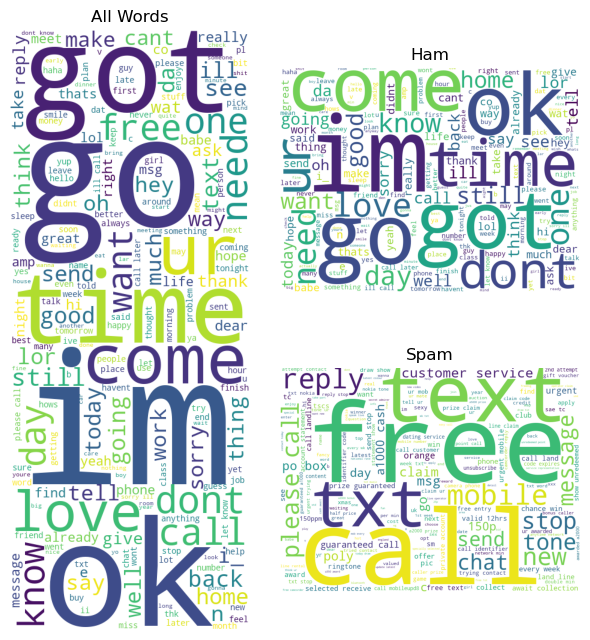

In [26]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(6, 6))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

#### Is there any overlap in the bigrams for the spam data and the ham data?

In [27]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

In [28]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

#### Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [29]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
dtype: int64

In [30]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

#### Explore the blog articles using the techniques discussed in the exploration lesson.

In [31]:
import acquire as a

In [38]:
blog_articles = a.get_blog_articles_data(refresh=False)
blog_articles

,title,content
0,Women in tech: Panelist Spotlight – Magdalena ...,\nCodeup is hosting a Women in Tech Panel in h...
1,Women in tech: Panelist Spotlight – Rachel Rob...,\nCodeup is hosting a Women in Tech Panel in h...
2,Women in Tech: Panelist Spotlight – Sarah Mellor,\nCodeup is hosting a Women in Tech Panel in ...
3,Women in Tech: Panelist Spotlight – Madeleine ...,\nCodeup is hosting a Women in Tech Panel in h...
4,Black Excellence in Tech: Panelist Spotlight –...,\n\nCodeup is hosting a Black Excellence in Te...
5,Black excellence in tech: Panelist Spotlight –...,\nCodeup is hosting our second Black Excellenc...


In [55]:
blog_articles.content[2]

'\xa0\nCodeup is hosting a Women in Tech Panel in honor of Women’s History Month on March 29th, 2023! To further celebrate, we’d like to spotlight each of our panelists leading up to the discussion to learn a bit about their respective experiences as women in the tech industry!\nMeet Sarah!\nSarah Mellor currently works as the Director of People Operations. She joined Codeup four and a half years ago as an Admissions Manager. She went on to build out and lead the Marketing and Admissions team, while picking up People Ops tasks and projects here and there until moving over to lead the People Ops team two years ago. Prior to Codeup, she worked at education-focused non-profits in Washington, DC and Boulder, Colorado. She graduated from Wake Forest University.\nWe asked Sarah how Codeup has impacted her career, and her response was “I have absolutely loved having the privilege to grow alongside Codeup. In my time here across multiple different roles and departments, I’ve seen a lot of chan

In [47]:
blog3_words = clean(blog_articles.content[3])

In [49]:
blog3_freq = pd.Series(blog3_words).value_counts()
blog3_freq

data            6
codeup          4
madeleine       4
woman           3
antonio         3
               ..
mathematics     1
studied         1
resident        1
longstanding    1
conversation    1
Length: 88, dtype: int64

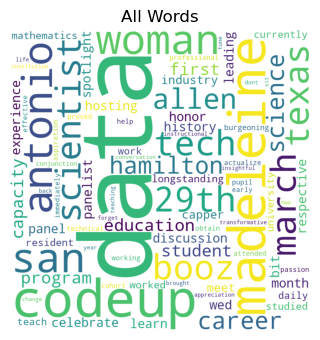

In [53]:
blog3_cloud = WordCloud(background_color='white', height=800, width=800).generate(' '.join(blog3_words))

plt.figure(figsize=(6, 6))
axs = [plt.axes([0, 0, .5, 1])]

axs[0].imshow(blog3_cloud)


axs[0].set_title('All Words')

for ax in axs: ax.axis('off')

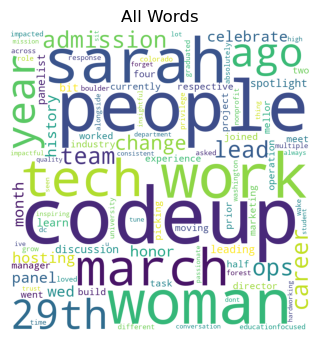

In [54]:
blog2_words = clean(blog_articles.content[2])
blog2_freq = pd.Series(blog2_words).value_counts()
blog2_cloud = WordCloud(background_color='white', height=800, width=800).generate(' '.join(blog2_words))

plt.figure(figsize=(6, 6))
axs = [plt.axes([0, 0, .5, 1])]

axs[0].imshow(blog2_cloud)


axs[0].set_title('All Words')

for ax in axs: ax.axis('off')

#### Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [ ]:
news_articles = a.get_news_articles_data(refresh=False)